In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/YoloVQA/yolov7

/content/gdrive/MyDrive/YoloVQA/yolov7


In [ ]:
!pip install -r requirements.txt

In [ ]:
import torch
from models.yolo import Model


#weights_path = '/content/gdrive/MyDrive/YoloVQA/yolov7/runs/train/exp7-cunstomBig/weights/best.pt'
weights_path ='/content/gdrive/MyDrive/YoloVQA/yolov7/runs/train/exp21-yolov7x/weights/best.pt'
cfg_path = '/content/gdrive/MyDrive/YoloVQA/yolov7/cfg/training/yolov7x.yaml'

model = Model(cfg_path).to('cuda')

checkpoint = torch.load(weights_path, map_location='cuda')

if isinstance(checkpoint['model'], torch.nn.Module):
    state_dict = checkpoint['model'].state_dict()
else:
    state_dict = checkpoint['model']

model.load_state_dict(state_dict, strict=False)



/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-5-3c4efcfa8ed3>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

<All keys matched successfully>

In [ ]:
!pip install torchinfo


In [ ]:
from torchinfo import summary
summary(model, input_size=(1, 3, 640, 640), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Model                                    [1, 3, 640, 640]          [1, 25200, 15]            --
├─Sequential: 1-1                        --                        --                        --
│    └─Conv: 2-1                         [1, 3, 640, 640]          [1, 40, 640, 640]         --
│    │    └─Conv2d: 3-1                  [1, 3, 640, 640]          [1, 40, 640, 640]         1,080
│    │    └─BatchNorm2d: 3-2             [1, 40, 640, 640]         [1, 40, 640, 640]         80
│    │    └─SiLU: 3-3                    [1, 40, 640, 640]         [1, 40, 640, 640]         --
│    └─Conv: 2-2                         [1, 40, 640, 640]         [1, 80, 320, 320]         --
│    │    └─Conv2d: 3-4                  [1, 40, 640, 640]         [1, 80, 320, 320]         28,800
│    │    └─BatchNorm2d: 3-5             [1, 80, 320, 320]         [1, 80, 320, 320]         160
│    │    └─SiLU: 3-6      

In [ ]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


In [ ]:
import openai
openai.api_key = ""



In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import cv2
import torch
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords
from PIL import Image as PILImage

# Using PICa in the VQA
class yoloVQA:
    def __init__(self, cfg_path, weights_path, data_yaml_path, device='cuda'):
        self.cfg_path = cfg_path
        self.weights_path = weights_path
        self.device = device
        self.data_yaml_path = data_yaml_path
        self.class_names = self.load_data_yaml()
        self.yolo_model = self.load_yolo_model()


    def load_data_yaml(self):
        import yaml
        with open(self.data_yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
        return data_yaml.get('names', [])

    def load_yolo_model(self):
        from models.experimental import attempt_load
        model = attempt_load(self.weights_path, map_location=self.device)
        model.eval()
        return model

    def detect(self, image_path):
        img0 = cv2.imread(image_path)
        assert img0 is not None, f"Image not found: {image_path}"

        # Preprocess image
        img = letterbox(img0, 640, stride=32, auto=True)[0]
        img = img.transpose(2, 0, 1)  # HWC to CHW
        img = torch.from_numpy(img).float().div(255.0).unsqueeze(0).to(self.device)

        with torch.no_grad():
            # Run inference
            pred = self.yolo_model(img)[0]
            # Apply Non-Max Suppression
            pred = non_max_suppression(
                pred,
                conf_thres=0.25,
                iou_thres=0.45,
                classes=None,  # None means detect all classes
                agnostic=False  # Class-agnostic NMS
            )

        prompts = []
        detected_objects = set()  # To avoid duplicate prompts
        colors = [[random.randint(0, 255) for _ in range(3)] for _ in self.class_names]

        if pred is None or len(pred[0]) == 0:
            prompts.append("No objects detected in the image.")
            print("No objects detected in the image.")
            return img0, prompts

        for det in pred:
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in det:
                # Filter out low-confidence predictions
                if conf < 0.25:
                    continue

                cls_name = self.class_names[int(cls)]
                bbox = [int(coord) for coord in xyxy]

                # Skip duplicate bounding boxes
                if tuple(bbox) in detected_objects:
                    continue
                detected_objects.add(tuple(bbox))

                # Generate prompts
                prompts.append(f"Detected a {cls_name} at {bbox} with confidence {conf:.2f}")

                # Draw bounding box and label on image
                color = colors[int(cls) % len(colors)]
                cv2.rectangle(img0, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
                cv2.putText(
                    img0,
                    f"{cls_name} {conf:.2f}",
                    (bbox[0], bbox[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color,
                    2,
                    cv2.LINE_AA
                )
        return img0, prompts


    def generate_answer(self, prompts, question):
        """
        Generate an intelligent answer based on detected objects and the user's question.
        """
        try:
            if not prompts or prompts[0] == "No objects detected in the image.":
                return "Sorry, I couldn't detect any objects in the image."

            combined_prompt = (
                "Objects detected in the image:\n" +
                "\n".join(prompts) +
                f"\n\nQuestion: {question}\nAnswer:"
            )

            response = openai.ChatCompletion.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant for visual question answering."},
                    {"role": "user", "content": combined_prompt}
                ],
                temperature=0.7,
                max_tokens=200,
                top_p=0.9
            )
            return response.choices[0].message["content"].strip()

        except openai.error.OpenAIError as e:
            print(f"Error during OpenAI API call: {e}")
            return "Sorry, I couldn't generate an answer due to an error."


    def run(self):
        """
        Main method to run the yoloVQA application.
        """
        print("Welcome to yoloVQA!")
        while True:
            try:
                image_path = input("\nEnter the path of the image (or type 'exit' to quit): ").strip()
                if image_path.lower() == "exit":
                    print("Exiting yoloVQA. Goodbye!")
                    break
                try:
                    img, prompts = self.detect(image_path)
                    pil_img = PILImage.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    display(pil_img)
                except FileNotFoundError:
                    print("The image file could not be found. Please check the path and try again.")
                    continue
                except Exception as e:
                    print(f"Error during detection: {e}")
                    continue

                time.sleep(2)
                while True:
                    question = input("\nAsk a question about the image (or type 'exit' to select another image): ").strip()
                    if question.lower() == "exit":
                        break
                    try:
                        answer = self.generate_answer(prompts, question)
                        print("\n--- Answer ---")
                        print(answer)
                        print("--------------")
                    except Exception as e:
                        print(f"Error during question answering: {e}")

            except Exception as e:
                print(f"Unexpected error: {e}")



In [ ]:
vqa = yoloVQA(
    cfg_path="/content/gdrive/MyDrive/YoloVQA/yolov7/cfg/training/yolov7.yaml",
    weights_path="/content/gdrive/MyDrive/YoloVQA/yolov7/runs/train/exp21-yolov7x/weights/best.pt",
    data_yaml_path="/content/gdrive/MyDrive/YoloVQA/yolov7/data_yaml",
    device="cuda" if torch.cuda.is_available() else "cpu"
)


Fusing layers... 
IDetect.fuse


Welcome to yoloVQA!

Enter the path of the image (or type 'exit' to quit): /content/gdrive/MyDrive/YoloVQA/data/test/images/images-47-_png.rf.241c4c18c825c5ada13a8b092bd8ec17.jpg


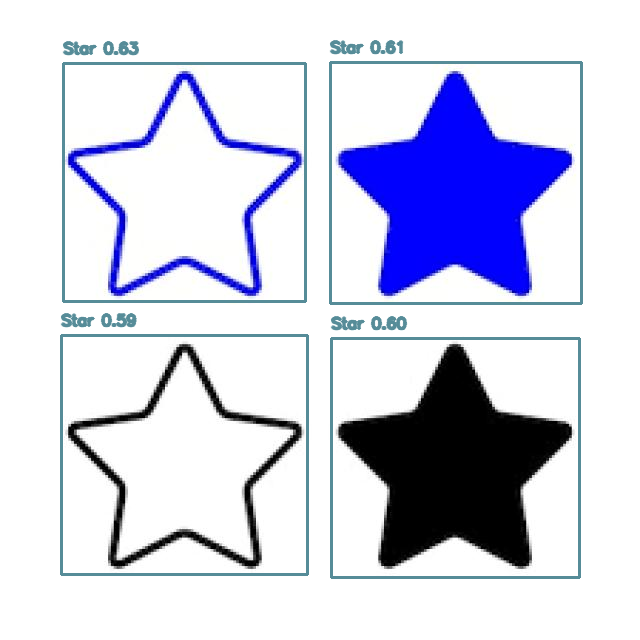


Ask a question about the image (or type 'exit' to select another image): How many stars in this image?

--- Answer ---
There are four stars detected in the image.
--------------

Ask a question about the image (or type 'exit' to select another image): exit

Enter the path of the image (or type 'exit' to quit): exit
Exiting yoloVQA. Goodbye!


In [ ]:
# test /content/gdrive/MyDrive/YoloVQA/data/test/images/images-47-_png.rf.241c4c18c825c5ada13a8b092bd8ec17.jpg
# questions: What object are there in the photo?
vqa.run()

Welcome to yoloVQA!

Enter the path of the image (or type 'exit' to quit): /content/gdrive/MyDrive/YoloVQA/data/test/images/73e56a8c-a43c-48ae-9437-ba7e5bed912c_png_jpg.rf.8e46cb1075efd1e5255fccf4b03e2327.jpg


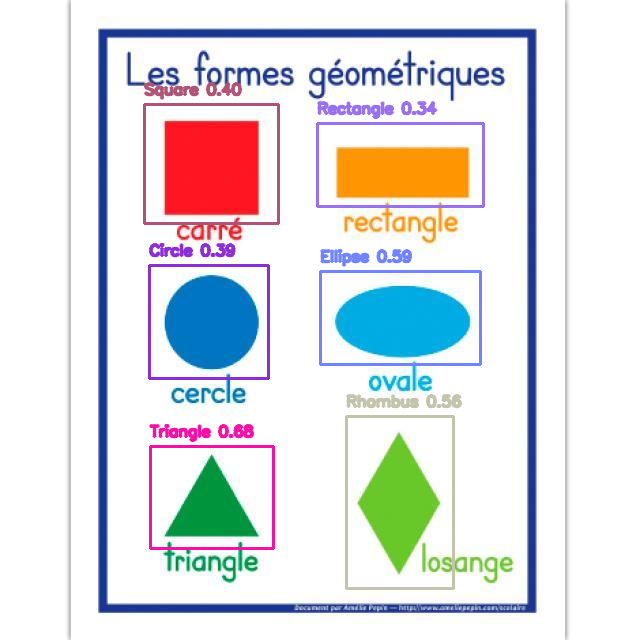


Ask a question about the image (or type 'exit' to select another image): what shapes in this image?

--- Answer ---
The shapes detected in the image are:

1. Triangle
2. Ellipse
3. Rhombus
4. Square
5. Circle
6. Rectangle
--------------

Ask a question about the image (or type 'exit' to select another image): which shapes in the left of Phombus?

--- Answer ---
The shapes located to the left of the Rhombus (which is detected at [346, 416, 453, 588]) are the Triangle and the Square. 

- The Triangle is detected at [150, 446, 273, 548].
- The Square is detected at [144, 104, 278, 223].

Both of these shapes are positioned to the left of the Rhombus.
--------------

Ask a question about the image (or type 'exit' to select another image): exit

Enter the path of the image (or type 'exit' to quit): exit
Exiting yoloVQA. Goodbye!


In [ ]:
# test2  /content/gdrive/MyDrive/YoloVQA/data/test/images/73e56a8c-a43c-48ae-9437-ba7e5bed912c_png_jpg.rf.8e46cb1075efd1e5255fccf4b03e2327.jpg
vqa.run()

In [ ]:
import json
import torch
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

class YoloVQAEvaluator:
    def __init__(self, vqa_model, embedding_model_name="all-MiniLM-L6-v2"):
        self.vqa_model = vqa_model
        self.embedding_model = SentenceTransformer(embedding_model_name)

    def compute_embedding(self, text):
        return self.embedding_model.encode(text, convert_to_tensor=True)

    def cosine_similarity(self, emb1, emb2):
        emb1 = emb1 / torch.norm(emb1)
        emb2 = emb2 / torch.norm(emb2)
        return torch.dot(emb1, emb2).item()

    def preprocess_text(self, text):
        import re
        text = re.sub(r"the image contains|including|multiple shapes|most confidently detected shape is", "", text, flags=re.IGNORECASE)

        text = re.sub(r"[^\w\s]", "", text)
        text = text.strip().lower()
        return text

    def sort_text(self, text):
        words = text.split(", ")
        sorted_words = sorted(words)
        return ", ".join(sorted_words)

    def evaluate(self, vqa_dataset_path):
        with open(vqa_dataset_path, "r") as f:
            vqa_data = json.load(f)

        total_similarity = 0.0
        total_coverage = 0.0
        num_samples = len(vqa_data)
        individual_scores = []

        print("Starting evaluation...")
        for entry in tqdm(vqa_data, desc="Evaluating"):
            image_path = entry["image"]
            question = entry["question"]
            ground_truth_answer = entry["answer"]

            try:
                _, prompts = self.vqa_model.detect(image_path)
                predicted_answer = self.vqa_model.generate_answer(prompts, question)
                ground_truth_answer = self.sort_text(self.preprocess_text(ground_truth_answer))
                predicted_answer = self.sort_text(self.preprocess_text(predicted_answer))
                gt_embedding = self.compute_embedding(ground_truth_answer)
                pred_embedding = self.compute_embedding(predicted_answer)
                similarity = self.cosine_similarity(gt_embedding, pred_embedding)
                total_similarity += similarity

                individual_scores.append({
                    "image": image_path,
                    "question": question,
                    "ground_truth": ground_truth_answer,
                    "predicted": predicted_answer,
                    "similarity": similarity,
                })
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                continue

        # Calculate average metrics
        average_similarity = total_similarity / num_samples if num_samples > 0 else 0.0

        print(f"Evaluation complete. Average similarity: {average_similarity:.4f}")
        return {
            "average_similarity": average_similarity,
            "individual_scores": individual_scores
        }




In [ ]:
evaluator = YoloVQAEvaluator(vqa)

vqa_dataset_path = "/content/gdrive/MyDrive/YoloVQA/data/test/vqa_dataset.json"
results = evaluator.evaluate(vqa_dataset_path)

output_results_path = "/content/gdrive/MyDrive/YoloVQA/data/test/evaluation_results.json"
with open(output_results_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=4)
print(f"Evaluation results saved to {output_results_path}")

Starting evaluation...


Evaluating:  41%|████▏     | 58/140 [00:43<00:40,  2.04it/s]

No objects detected in the image.
No objects detected in the image.


Evaluating:  46%|████▋     | 65/140 [00:46<00:27,  2.69it/s]

No objects detected in the image.
No objects detected in the image.
No objects detected in the image.


Evaluating:  48%|████▊     | 67/140 [00:46<00:19,  3.83it/s]

No objects detected in the image.


Evaluating:  95%|█████████▌| 133/140 [01:40<00:03,  1.91it/s]

No objects detected in the image.
No objects detected in the image.


Evaluating: 100%|██████████| 140/140 [01:46<00:00,  1.32it/s]

Evaluation complete. Average similarity: 0.7309
Evaluation results saved to /content/gdrive/MyDrive/YoloVQA/data/test/evaluation_results.json


In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import cv2
import torch
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords
from PIL import Image as PILImage

# Using PICa in the VQA
class yoloVQAwithoutPICa:
    def __init__(self, cfg_path, weights_path, data_yaml_path, device='cuda'):
        self.cfg_path = cfg_path
        self.weights_path = weights_path
        self.device = device
        self.data_yaml_path = data_yaml_path
        self.class_names = self.load_data_yaml()
        self.yolo_model = self.load_yolo_model()


    def load_data_yaml(self):
        import yaml
        with open(self.data_yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
        return data_yaml.get('names', [])

    def load_yolo_model(self):
        from models.experimental import attempt_load
        model = attempt_load(self.weights_path, map_location=self.device)
        model.eval()
        return model

    def detect(self, image_path):
        img0 = cv2.imread(image_path)
        assert img0 is not None, f"Image not found: {image_path}"

        img = letterbox(img0, 640, stride=32, auto=True)[0]
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).float().div(255.0).unsqueeze(0).to(self.device)

        with torch.no_grad():
            pred = self.yolo_model(img)[0]
            pred = non_max_suppression(
                pred,
                conf_thres=0.25,
                iou_thres=0.45,
                classes=None,
                agnostic=False
            )

        prompts = []
        detected_objects = set()
        colors = [[random.randint(0, 255) for _ in range(3)] for _ in self.class_names]

        if pred is None or len(pred[0]) == 0:
            prompts.append("No objects detected in the image.")
            print("No objects detected in the image.")
            return img0, prompts

        for det in pred:
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in det:
                if conf < 0.25:
                    continue

                cls_name = self.class_names[int(cls)]
                bbox = [int(coord) for coord in xyxy]

                if tuple(bbox) in detected_objects:
                    continue
                detected_objects.add(tuple(bbox))
                prompts.append(f"Detected a {cls_name} at {bbox} with confidence {conf:.2f}")
                color = colors[int(cls) % len(colors)]
                cv2.rectangle(img0, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
                cv2.putText(
                    img0,
                    f"{cls_name} {conf:.2f}",
                    (bbox[0], bbox[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color,
                    2,
                    cv2.LINE_AA
                )
        return img0, prompts


    def generate_answer(self, prompts, question):
        """
        Generate an intelligent answer based on detected objects and the user's question.
        """
        try:
            if not prompts or prompts[0] == "No objects detected in the image.":
                return "Sorry, I couldn't detect any objects in the image."

            combined_prompt = (
                "\n".join(prompts) +
                f"\n\nQuestion: {question}\nAnswer:"
            )

            response = openai.ChatCompletion.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "user", "content": combined_prompt}
                ],
                temperature=0.7,
                max_tokens=200,
                top_p=0.9
            )

            return response.choices[0].message["content"].strip()

        except openai.error.OpenAIError as e:
            print(f"Error during OpenAI API call: {e}")
            return "Sorry, I couldn't generate an answer due to an error."


    def run(self):
        """
        Main method to run the yoloVQA application.
        """
        print("Welcome to yoloVQA!")
        while True:
            try:
                image_path = input("\nEnter the path of the image (or type 'exit' to quit): ").strip()
                if image_path.lower() == "exit":
                    print("Exiting yoloVQA. Goodbye!")
                    break
                try:
                    img, prompts = self.detect(image_path)
                    pil_img = PILImage.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    display(pil_img)
                except FileNotFoundError:
                    print("The image file could not be found. Please check the path and try again.")
                    continue
                except Exception as e:
                    print(f"Error during detection: {e}")
                    continue

                time.sleep(2)
                while True:
                    question = input("\nAsk a question about the image (or type 'exit' to select another image): ").strip()
                    if question.lower() == "exit":
                        break
                    try:
                        answer = self.generate_answer(prompts, question)
                        print("\n--- Answer ---")
                        print(answer)
                        print("--------------")
                    except Exception as e:
                        print(f"Error during question answering: {e}")

            except Exception as e:
                print(f"Unexpected error: {e}")


In [ ]:
vqa_dataset_path = yoloVQAwithoutPICa(
    cfg_path="/content/gdrive/MyDrive/YoloVQA/yolov7/cfg/training/yolov7.yaml",
    weights_path="/content/gdrive/MyDrive/YoloVQA/yolov7/runs/train/exp21-yolov7x/weights/best.pt",
    data_yaml_path="/content/gdrive/MyDrive/YoloVQA/yolov7/data_yaml",
    device="cuda" if torch.cuda.is_available() else "cpu"
)


/content/gdrive/MyDrive/YoloVQA/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(w, map_location=map_location)  # load


Fusing layers... 
IDetect.fuse


In [ ]:
evaluator = YoloVQAEvaluator(vqa_dataset_path)

vqa_dataset_path = "/content/gdrive/MyDrive/YoloVQA/data/test/vqa_dataset.json"
results = evaluator.evaluate(vqa_dataset_path)

output_results_path = "/content/gdrive/MyDrive/YoloVQA/data/test/evaluation_results_withouPICa.json"
with open(output_results_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=4)
print(f"Evaluation results saved to {output_results_path}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Starting evaluation...


Evaluating:  42%|████▏     | 59/140 [01:30<01:41,  1.26s/it]

No objects detected in the image.
No objects detected in the image.


Evaluating:  46%|████▌     | 64/140 [01:38<01:41,  1.34s/it]

No objects detected in the image.
No objects detected in the image.


Evaluating:  47%|████▋     | 66/140 [01:38<01:09,  1.06it/s]

No objects detected in the image.
No objects detected in the image.


Evaluating:  95%|█████████▌| 133/140 [03:31<00:08,  1.24s/it]

No objects detected in the image.
No objects detected in the image.


Evaluating: 100%|██████████| 140/140 [03:45<00:00,  1.61s/it]

Evaluation complete. Average similarity: 0.5999
Evaluation results saved to /content/gdrive/MyDrive/YoloVQA/data/test/evaluation_results_withouPICa.json
